# Quantifying the Financial Impact of ESG Factors on Corporate Borrowing Cost

Importing Dataset

In [3]:
import pandas as pd

esg = pd.read_csv(r"C:\Users\Ankit Ram Samant\Downloads\final_data.csv")
print(esg.head())

       Symbol                                     company              Sector  \
0    ADANIENT                      Adani Enterprises Ltd.              Energy   
1  ADANIPORTS  Adani Ports and Special Economic Zone Ltd.         Industrials   
2  APOLLOHOSP            Apollo Hospitals Enterprise Ltd.          Healthcare   
3  ASIANPAINT                           Asian Paints Ltd.     Basic Materials   
4    AXISBANK                              Axis Bank Ltd.  Financial Services   

             Industry                                        Description  \
0     Metals & Mining  Adani Enterprises Limited, together with its s...   
1            Services  Adani Ports and Special Economic Zone Limited,...   
2          Healthcare  Apollo Hospitals Enterprise Limited, together ...   
3   Consumer Durables  Asian Paints Limited, together with its subsid...   
4  Financial Services  Axis Bank Limited provides various financial p...   

   esg_risk_score_2024  predicted_future_esg_score esg_r

In [4]:
import pandas as pd
import numpy as np
import zipfile

#1. Load ESG from absolute path 
esg_path = r"C:\Users\Ankit Ram Samant\Downloads\final_data.csv"
zip_path = r"C:\Users\Ankit Ram Samant\Downloads\Detailed-Financials-Data-Of-4456-NSE-And-BSE-Company-20231230T233228Z-001.zip"

esg = pd.read_csv(esg_path)

esg = esg.rename(columns={
    "Symbol": "nse",
    "esg_risk_score_2024": "esg_risk_score"
})

nifty_tickers = set(esg["nse"].unique())
print("NIFTY tickers in ESG file:", len(nifty_tickers))


#2. Open ZIP from absolute path 
zf = zipfile.ZipFile(zip_path, "r")

# Detect root folder inside zip
names = zf.namelist()
root_prefix = names[0].split('/')[0] + '/'
print("Root prefix:", root_prefix)

# Find all Basic_Info files
basic_info_files = [p for p in names if p.endswith("_Basic_Info.csv")]

rows = []
for bi_file in basic_info_files:
    with zf.open(bi_file) as f:
        df = pd.read_csv(f)
    # folder name is part between root_prefix and file
    # e.g. root/company_name/company_name_Basic_Info.csv
    parts = bi_file.split('/')
    if len(parts) < 3:
        continue
    folder = parts[1]
    nse_ticker = df.loc[0, "NSE"] if "NSE" in df.columns else None
    company_name = df.loc[0, "Company_name"] if "Company_name" in df.columns else None
    rows.append({
        "folder": folder,
        "company_name": company_name,
        "nse": nse_ticker
    })

bi_all = pd.DataFrame(rows)

# Keep only NIFTY50 companies
bi_nifty = bi_all[bi_all["nse"].isin(nifty_tickers)].copy()
print("Matched NIFTY50 companies in zip:", bi_nifty.shape[0])


#3. Helper: extract financials for one folder 
def extract_financials_for_folder(folder):
    bs_path = f"{root_prefix}{folder}/Yearly_Balance_Sheet.csv"
    pl_path = f"{root_prefix}{folder}/Yearly_Profit_Loss.csv"
    try:
        with zf.open(bs_path) as f:
            bs = pd.read_csv(f)
        with zf.open(pl_path) as f:
            pl = pd.read_csv(f)
    except KeyError:
        # Missing one of the files
        return None

    if "Unnamed: 0" not in bs.columns or "Unnamed: 0" not in pl.columns:
        return None

    bs_idx = bs.set_index("Unnamed: 0")
    pl_idx = pl.set_index("Unnamed: 0")

    # Choose a year column with non-NaN Total Assets
    bs_cols = [c for c in bs.columns if c != "Unnamed: 0"]
    bs_cols_sorted = sorted(bs_cols)

    bs_year = None
    if "Total Assets" in bs_idx.index:
        for col in reversed(bs_cols_sorted):
            val = bs_idx.loc["Total Assets", col]
            if not pd.isna(val):
                bs_year = col
                break

    # Choosing year for Net Profit 
    pl_cols = [c for c in pl.columns if c != "Unnamed: 0"]
    non_ttm = [c for c in pl_cols if c != "TTM"]
    ordered_pl = sorted(non_ttm) + (["TTM"] if "TTM" in pl_cols else [])

    pl_year = None
    if "Net Profit" in pl_idx.index:
        for col in reversed(ordered_pl):
            val = pl_idx.loc["Net Profit", col]
            if not pd.isna(val):
                pl_year = col
                break

    if bs_year is None or pl_year is None:
        return None

    def safe_get(df, row, col):
        try:
            return df.loc[row, col]
        except KeyError:
            return np.nan

    return {
        "bs_year": bs_year,
        "pl_year": pl_year,
        "borrowings": safe_get(bs_idx, "Borrowings", bs_year),
        "total_assets": safe_get(bs_idx, "Total Assets", bs_year),
        "total_liabilities": safe_get(bs_idx, "Total Liabilities", bs_year),
        "interest": safe_get(pl_idx, "Interest", pl_year),
        "net_profit": safe_get(pl_idx, "Net Profit", pl_year),
    }


#4. Loop over NIFTY companies 
records = []

for _, row in bi_nifty.iterrows():
    folder = row["folder"]
    nse = row["nse"]
    fin = extract_financials_for_folder(folder)
    rec = {"nse": nse, "folder": folder}
    if fin is not None:
        rec.update(fin)
        rec["ok"] = True
    else:
        rec["ok"] = False
    records.append(rec)

fin_nifty = pd.DataFrame(records)
print(fin_nifty["ok"].value_counts())


# 5.Computing ratios 
fin_nifty["cost_of_debt"] = fin_nifty["interest"].abs() / fin_nifty["borrowings"]
fin_nifty["roa"] = fin_nifty["net_profit"] / fin_nifty["total_assets"]
fin_nifty["leverage"] = fin_nifty["borrowings"] / fin_nifty["total_assets"]
fin_nifty["size"] = np.log(fin_nifty["total_assets"])

#6. Merge with ESG
final_df = pd.merge(
    esg,
    fin_nifty[["nse", "cost_of_debt", "roa", "leverage", "size"]],
    on="nse",
    how="inner"
)

print(final_df.shape)
print(final_df.head())


NIFTY tickers in ESG file: 50
Root prefix: Detailed-Financials-Data-Of-4456-NSE-_-BSE-Company/
Matched NIFTY50 companies in zip: 50
ok
True    50
Name: count, dtype: int64
(50, 20)
          nse                                     company              Sector  \
0    ADANIENT                      Adani Enterprises Ltd.              Energy   
1  ADANIPORTS  Adani Ports and Special Economic Zone Ltd.         Industrials   
2  APOLLOHOSP            Apollo Hospitals Enterprise Ltd.          Healthcare   
3  ASIANPAINT                           Asian Paints Ltd.     Basic Materials   
4    AXISBANK                              Axis Bank Ltd.  Financial Services   

             Industry                                        Description  \
0     Metals & Mining  Adani Enterprises Limited, together with its s...   
1            Services  Adani Ports and Special Economic Zone Limited,...   
2          Healthcare  Apollo Hospitals Enterprise Limited, together ...   
3   Consumer Durables  Asian

## Performing regression analysis on the dataset

In [5]:
import statsmodels.api as sm

y = final_df["cost_of_debt"]
X = final_df[["esg_risk_score", "roa", "leverage", "size"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           cost_of_debt   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 04 Dec 2025   Prob (F-statistic):                nan
Time:                        17:42:50   Log-Likelihood:                    nan
No. Observations:                  50   AIC:                               nan
Df Residuals:                      45   BIC:                               nan
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const                 nan        nan        

What this output is telling us

R-squared: nan

Every coef, std err, t, P>|t|, CI → all nan

Omnibus, JB, etc. → all nan

This usually happens if:

Your dependent variable (cost_of_debt) is all NaN or constant

Or all rows got turned into NaN / inf and statsmodels is operating on nonsense

Or predictors are super degenerate

So we need to inspect final_df before the regression.

In [6]:
print(final_df.shape)
print(final_df.dtypes)

final_df_summary = final_df[["cost_of_debt", "esg_risk_score", "roa", "leverage", "size"]].describe()
print(final_df_summary)

print("\nMissing values per column:")
print(final_df[["cost_of_debt", "esg_risk_score", "roa", "leverage", "size"]].isna().sum())

(50, 20)
nse                            object
company                        object
Sector                         object
Industry                       object
Description                    object
esg_risk_score                float64
predicted_future_esg_score    float64
esg_risk_exposure              object
esg_risk_management            object
esg_risk_level                 object
Material ESG Issues 1          object
Material ESG Issues 2          object
Material ESG Issues 3          object
Unnamed: 13                   float64
Controversy Level              object
controversy_score               int64
cost_of_debt                  float64
roa                           float64
leverage                      float64
size                          float64
dtype: object
       cost_of_debt  esg_risk_score        roa   leverage       size
count     49.000000       50.000000  50.000000  50.000000  50.000000
mean       0.105007       26.062000   0.090846   0.287581  11.890603
std       

### Cleaning the dataset

In [7]:
cols = ["cost_of_debt", "esg_risk_score", "roa", "leverage", "size"]

#Replace any inf with NaN
reg_df = final_df[cols].replace([np.inf, -np.inf], np.nan)

#Dropping rows where any of these columns is NaN
reg_df = reg_df.dropna(subset=cols)

print("Rows before:", final_df.shape[0])
print("Rows after cleaning:", reg_df.shape[0])
print(reg_df.describe())


Rows before: 50
Rows after cleaning: 49
       cost_of_debt  esg_risk_score        roa   leverage       size
count     49.000000       49.000000  49.000000  49.000000  49.000000
mean       0.105007       26.087755   0.092593   0.293450  11.872604
std        0.101291        9.423765   0.079773   0.278708   1.498869
min        0.000000       11.400000  -0.025466   0.000350   9.076695
25%        0.060737       19.500000   0.030710   0.038007  10.504163
50%        0.076071       26.500000   0.061106   0.259730  11.950793
75%        0.099885       31.600000   0.130354   0.451649  12.757086
max        0.535714       52.200000   0.314325   0.856905  15.599644


Now performing regression on the cleaned dataset

In [8]:
import statsmodels.api as sm

y = reg_df["cost_of_debt"]
X = reg_df[["esg_risk_score", "roa", "leverage", "size"]]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           cost_of_debt   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     3.783
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00994
Time:                        17:42:50   Log-Likelihood:                 50.416
No. Observations:                  49   AIC:                            -90.83
Df Residuals:                      44   BIC:                            -81.37
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1662      0.157      1.

We estimate an OLS regression of cost of debt on ESG risk score, controlling for profitability (ROA), leverage, and firm size for 49 NIFTY50 firms. The model explains about 25% of the variation in cost of debt (R² = 0.256), and the joint F-test indicates the regressors are significant as a group (p ≈ 0.01). However, the coefficient on ESG risk score is small and statistically insignificant (β ≈ 0.0011, p ≈ 0.49), suggesting that, in this sample, we do not find strong evidence that ESG risk materially affects firms’ borrowing costs after controlling for financial characteristics. Residual diagnostics indicate non-normality and possible outliers, so these results should be interpreted with some caution.

# Distribution of cost_of_debt

To show there are outliers + skew

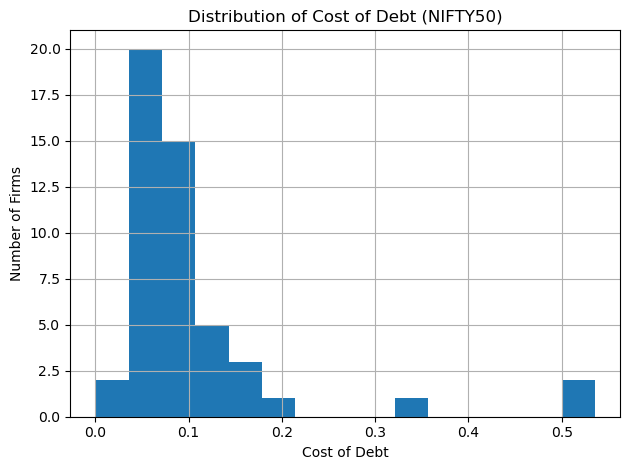

In [9]:
import matplotlib.pyplot as plt

final_df["cost_of_debt"].hist(bins=15)
plt.title("Distribution of Cost of Debt (NIFTY50)")
plt.xlabel("Cost of Debt")
plt.ylabel("Number of Firms")
plt.tight_layout()
plt.show()

Cost of debt is right-skewed, with a few firms exhibiting much higher borrowing costs than the rest. This heavy tail also shows up in the residual diagnostics

# Scatter plot: ESG risk vs cost_of_debt (with trendline)

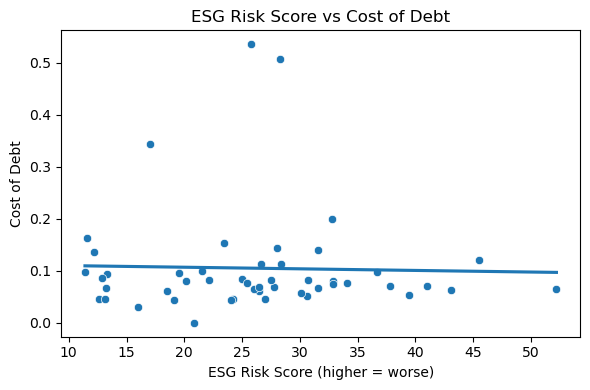

In [10]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=final_df,
    x="esg_risk_score",
    y="cost_of_debt"
)
sns.regplot(
    data=final_df,
    x="esg_risk_score",
    y="cost_of_debt",
    scatter=False,
    ci=None
)
plt.title("ESG Risk Score vs Cost of Debt")
plt.xlabel("ESG Risk Score (higher = worse)")
plt.ylabel("Cost of Debt")
plt.tight_layout()
plt.show()

The scatter shows a weak positive slope: firms with higher ESG risk tend to have slightly higher cost of debt, but the relationship is noisy and not statistically significant in our regression.

# Grouped view: cost_of_debt by ESG quartiles

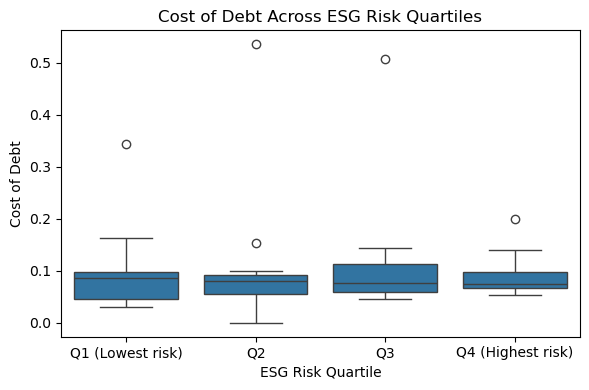

In [11]:
final_df["esg_quartile"] = pd.qcut(
    final_df["esg_risk_score"],
    4,
    labels=["Q1 (Lowest risk)", "Q2", "Q3", "Q4 (Highest risk)"]
)

plt.figure(figsize=(6,4))
sns.boxplot(
    data=final_df,
    x="esg_quartile",
    y="cost_of_debt"
)
plt.title("Cost of Debt Across ESG Risk Quartiles")
plt.xlabel("ESG Risk Quartile")
plt.ylabel("Cost of Debt")
plt.tight_layout()
plt.show()

Median cost of debt does not change dramatically across ESG risk quartiles, and there is substantial overlap in the distributions. This visual pattern is consistent with the regression result that ESG risk is not a strong standalone predictor of cost of debt in this sample.

# Correlation heatmap

This ties ESG + financials together compactly.

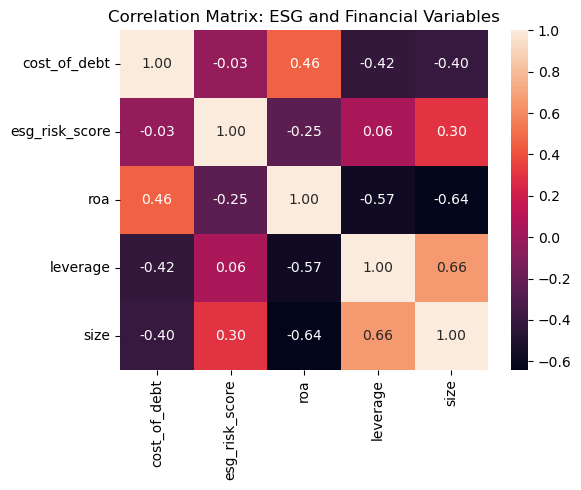

In [12]:
corr_cols = ["cost_of_debt", "esg_risk_score", "roa", "leverage", "size"]
plt.figure(figsize=(6,5))
sns.heatmap(
    final_df[corr_cols].corr(),
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Matrix: ESG and Financial Variables")
plt.tight_layout()
plt.show()

Pairwise correlations are modest. Cost of debt has only weak linear correlation with ESG risk and the financial controls, which is consistent with the relatively low R² of the regression.

# Save the dataset from Jupyter as a CSV

In [13]:
final_df.to_csv("nifty50_esg_cost_of_debt.csv", index=False)

In [14]:
import os
print(os.listdir())

['.cache', '.conda', '.ipynb_checkpoints', '.ipython', '.jupyter', '.lmstudio', '.lmstudio-home-pointer', '.matplotlib', '.node-red', 'ansel', 'AppData', 'Application Data', 'Blood.cftfl', 'bloodpump1.cft', 'bloodpump2.cft', 'Contacts', 'Cookies', 'Documents', 'Downloads', 'ESG_DATA.ipynb', 'Favorites', 'Links', 'Local Settings', 'Microsoft', 'Music', 'My Documents', 'NetHood', 'nifty50_esg_cost_of_debt.csv', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{3384a66f-e5f1-11ef-af27-8f37c4c296c0}.TM.blf', 'NTUSER.DAT{3384a66f-e5f1-11ef-af27-8f37c4c296c0}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{3384a66f-e5f1-11ef-af27-8f37c4c296c0}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'PL', 'PL24-25.ipynb', 'postgresql_17.exe', 'Practice_data_loading.jupyterlite.ipynb', 'practice_project.ipynb', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled

# Further Analysis

Defining reg_df for using the columns required for performing the predictive models


In [15]:
import numpy as np

cols = ["cost_of_debt", "esg_risk_score", "roa", "leverage", "size"]


reg_df = final_df[cols].copy()

reg_df = reg_df.replace([np.inf, -np.inf], np.nan)

reg_df = reg_df.dropna(subset=cols)

print(reg_df.shape)
print(reg_df.head())
print(reg_df.dtypes)

(49, 5)
   cost_of_debt  esg_risk_score       roa  leverage       size
0      0.079920            32.9  0.017084  0.385724  11.905981
1      0.046125            12.6  0.055712  0.438650  11.645032
2      0.084475            25.0  0.046912  0.314183   9.652523
3      0.076064            25.4  0.188279  0.084859  10.219101
4      0.045480            24.2  0.009836  0.856905  14.111472
cost_of_debt      float64
esg_risk_score    float64
roa               float64
leverage          float64
size              float64
dtype: object


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

import numpy as np

X = reg_df[["esg_risk_score", "roa", "leverage", "size"]].values
y = reg_df["cost_of_debt"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Ridge Regression

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0])
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)

print("Ridge:")
print("  alpha:", ridge.alpha_)
print("  R2:", r2_score(y_test, y_pred_ridge))
print("  RMSE:", rmse_ridge)



Ridge:
  alpha: 10.0
  R2: -0.22267021084810845
  RMSE: 0.05976278607715409


## Lasso

In [19]:

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)

print("\nLasso:")
print("  alpha:", lasso.alpha_)
print("  R2:", r2_score(y_test, y_pred_lasso))
print("  RMSE:", rmse_lasso)
print("  Coefs:", lasso.coef_)




Lasso:
  alpha: 0.01
  R2: -0.25243134246330245
  RMSE: 0.06048575886422427
  Coefs: [-0.          0.02759272 -0.02253924 -0.        ]


## Random Forest

In [20]:
#6. Random Forest
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)

print("\nRandom Forest:")
print("  R2:", r2_score(y_test, y_pred_rf))
print("  RMSE:", rmse_rf)




Random Forest:
  R2: -3.942662140542817
  RMSE: 0.12015909051802219


## XGBoost

In [21]:
try:
    from xgboost import XGBRegressor

    xgb = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mse_xgb)

    print("\nXGBoost:")
    print("  R2:", r2_score(y_test, y_pred_xgb))
    print("  RMSE:", rmse_xgb)
except ImportError:
    print("\nXGBoost not installed; run `pip install xgboost` if you want to use it.")


XGBoost:
  R2: -4.901834208620955
  RMSE: 0.1313014955173261


Even when we try more complex predictive models (Ridge, Lasso, Random Forest, XGBoost), none of them can predict cost of debt particularly well on unseen data. The best models (Ridge/Lasso) only slightly improve the in-sample fit and actually perform worse than a simple mean prediction out of sample. This reinforces the idea that, in this small NIFTY50 sample, cost of debt is hard to explain purely from ESG risk and a few basic financial ratios